In [1]:
from pathlib import Path

# --------------------------------------------------
# Robust project root detection (local & prof)
# --------------------------------------------------
cwd = Path.cwd().resolve()

# Case 1: notebook launched from project root
if (cwd / "data" / "intermediate").exists():
    ROOT = cwd

# Case 2: notebook launched from notebooks/
elif (cwd.parent / "data" / "intermediate").exists():
    ROOT = cwd.parent

else:
    raise FileNotFoundError(
        f"Cannot locate project root from cwd={cwd}. "
        "Expected 'data/intermediate/' in cwd or parent."
    )

DATA = ROOT / "data"
INTER = DATA / "intermediate"

INTER.mkdir(parents=True, exist_ok=True)

print("ROOT :", ROOT)
print("INTER:", INTER)


ROOT : C:\Users\hamza\OneDrive\Desktop\projet-ada-hk
INTER: C:\Users\hamza\OneDrive\Desktop\projet-ada-hk\data\intermediate


MASTER DATASET CREATED: C:\Users\hamza\OneDrive\Desktop\projet-ada-hk\data\intermediate\master_panel_2015_2024.csv
Shape: (393, 16)
Columns: ['canton', 'year', 'reg_total', 'ev_reg_count', 'ev_reg_share', 'canton_code', 'motorization_rate_per_1000', 'gdp_per_capita_chf', 'pop_dec31', 'arrivals', 'departures', 'greens_share', 'summer_temp_c', 'winter_temp_c', 'co2_emissions_mt', 'price_elcom_cts']
   canton  year  reg_total  ev_reg_count  ev_reg_share canton_code  \
0  Aargau  2015    50384.0         115.0      0.228247          AG   
1  Aargau  2016    49572.0         115.0      0.231986          AG   
2  Aargau  2016    49572.0         115.0      0.231986          AG   
3  Aargau  2016    49572.0         115.0      0.231986          AG   
4  Aargau  2016    49572.0         115.0      0.231986          AG   

   motorization_rate_per_1000  gdp_per_capita_chf  pop_dec31  arrivals  \
0                  585.915816         64040.47349   653675.0   24929.0   
1                  589.959842  

,canton,year,reg_total,ev_reg_count,ev_reg_share,canton_code,motorization_rate_per_1000,gdp_per_capita_chf,pop_dec31,arrivals,departures,greens_share,summer_temp_c,winter_temp_c,co2_emissions_mt,price_elcom_cts
1,Aargau,2016,49572.0,115.0,0.231986,AG,589.959842,63974.67966,663462.0,26025.0,18554.0,0.015823,18.07,0.93,3.44,8.121267
2,Aargau,2016,49572.0,115.0,0.231986,AG,589.959842,63974.67966,663462.0,26025.0,18554.0,0.015823,18.07,0.93,3.44,8.121267
3,Aargau,2016,49572.0,115.0,0.231986,AG,589.959842,63974.67966,663462.0,26025.0,18554.0,0.015823,18.07,0.93,3.44,8.121267
4,Aargau,2016,49572.0,115.0,0.231986,AG,589.959842,63974.67966,663462.0,26025.0,18554.0,0.015823,18.07,0.93,3.44,8.121267
8,Aargau,2020,37082.0,397.0,1.070600,AG,589.662387,63928.76128,694072.0,25712.0,19010.0,0.016722,18.07,0.93,3.44,7.508200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Zug,2022,19542.0,460.0,2.353904,ZG,NaN,192957.78069,131164.0,6679.0,5693.0,0.028409,19.03,1.77,0.63,8.875023
380,Zürich,2015,136760.0,471.0,0.344399,ZH,500.359525,99315.95436,1466424.0,60419.0,44462.0,0.017812,18.23,1.47,7.64,9.109593
381,Zürich,2015,136760.0,471.0,0.344399,ZH,500.359525,99315.95436,1466424.0,60419.0,44462.0,0.017812,18.23,1.47,7.64,9.109593
382,Zürich,2015,136760.0,471.0,0.344399,ZH,500.359525,99315.95436,1466424.0,60419.0,44462.0,0.017812,18.23,1.47,7.64,9.109593



=== % of missing values per column ===
greens_share                  0.572519
motorization_rate_per_1000    0.129771
winter_temp_c                 0.127226
canton_code                   0.127226
departures                    0.127226
arrivals                      0.127226
pop_dec31                     0.127226
summer_temp_c                 0.127226
co2_emissions_mt              0.127226
gdp_per_capita_chf            0.025445
ev_reg_share                  0.000000
ev_reg_count                  0.000000
canton                        0.000000
year                          0.000000
reg_total                     0.000000
price_elcom_cts               0.000000
dtype: float64

Columns with missing values :
greens_share                  0.572519
motorization_rate_per_1000    0.129771
winter_temp_c                 0.127226
canton_code                   0.127226
departures                    0.127226
arrivals                      0.127226
pop_dec31                     0.127226
summer_temp_c    

,canton,year,reg_total,ev_reg_count,ev_reg_share,canton_code,motorization_rate_per_1000,gdp_per_capita_chf,pop_dec31,arrivals,departures,greens_share,summer_temp_c,winter_temp_c,co2_emissions_mt,price_elcom_cts
count,393,393.000000,393.000000,393.000000,393.000000,343,342.000000,383.000000,3.430000e+02,343.000000,343.000000,168.000000,343.000000,343.000000,343.000000,393.000000
unique,27,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ticino,NaN,NaN,NaN,NaN,LU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,18,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2019.274809,20687.506361,188.671756,0.906160,NaN,569.583486,84999.411079,3.037528e+05,12463.982507,10062.355685,0.019267,17.553440,0.736968,1.500087,9.004408
std,NaN,2.832177,24814.576596,314.233123,0.732002,NaN,75.332300,34538.040229,3.300937e+05,13671.979999,10609.290204,0.013158,1.976919,1.526900,1.636811,1.096391
min,NaN,2015.000000,172.000000,0.000000,0.000000,NaN,322.530008,52365.853080,1.597400e+04,537.000000,503.000000,0.000000,12.570000,-2.000000,0.080000,6.461467
25%,NaN,2017.000000,3294.000000,22.000000,0.269320,NaN,535.031574,65218.412885,5.612700e+04,2037.000000,1708.000000,0.011659,16.030000,-0.670000,0.280000,8.611428
50%,NaN,2019.000000,14532.000000,73.000000,0.756783,NaN,580.078347,72395.945440,1.930700e+05,8449.000000,8185.000000,0.017812,18.030000,0.930000,0.990000,8.875023
75%,NaN,2022.000000,25572.000000,217.000000,1.392882,NaN,626.196603,87545.843310,4.147335e+05,14453.500000,12334.000000,0.028409,19.220000,1.770000,2.050000,9.218929



=== Histograms of important features ===


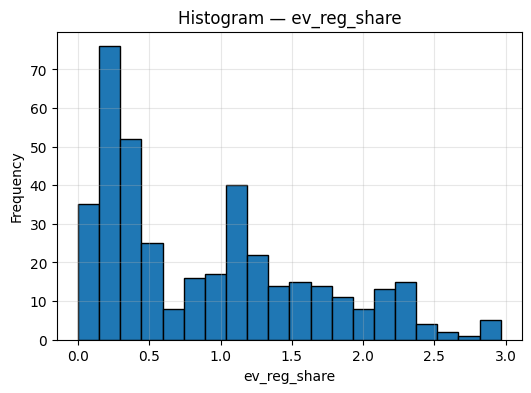

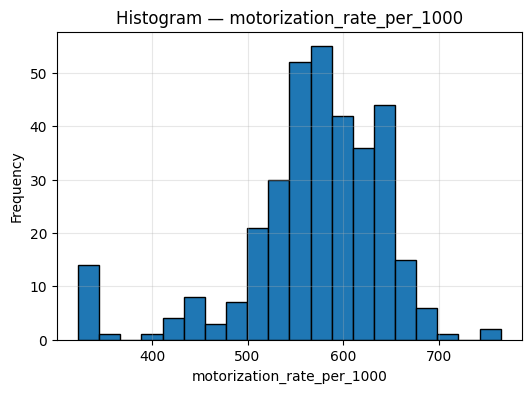

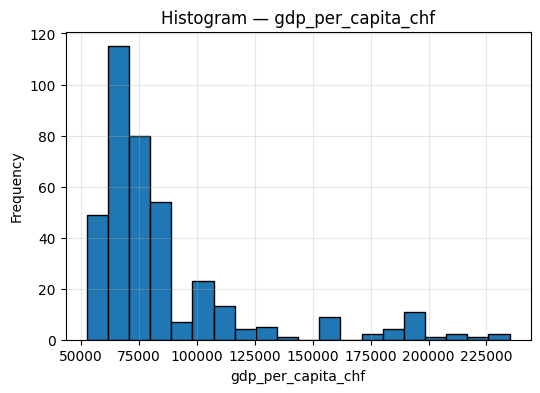

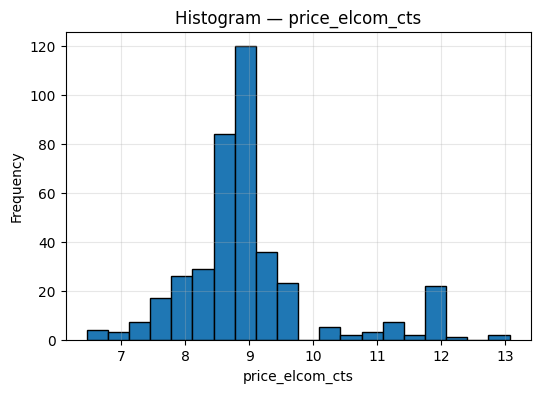

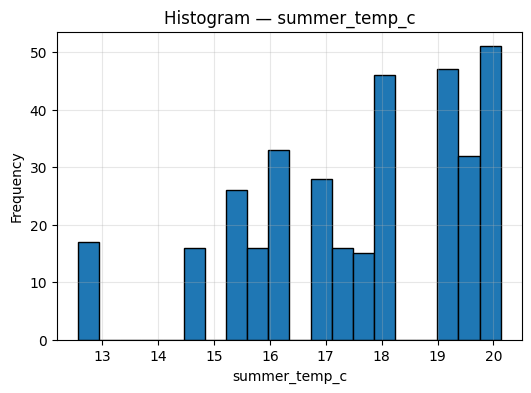

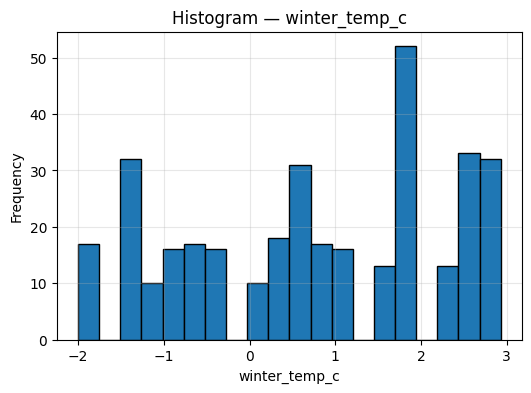

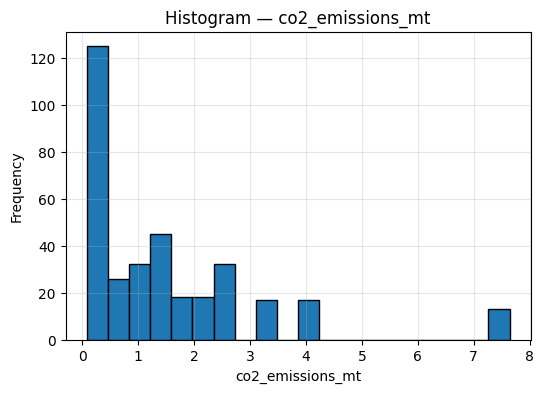

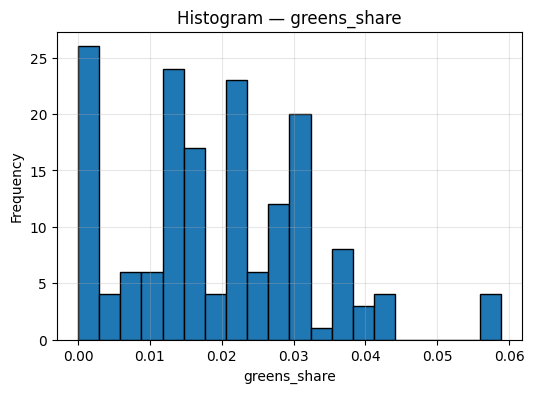

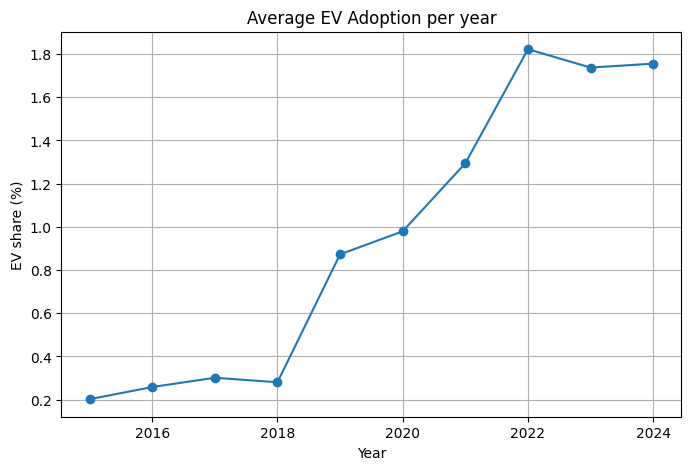

<Figure size 1400x500 with 0 Axes>

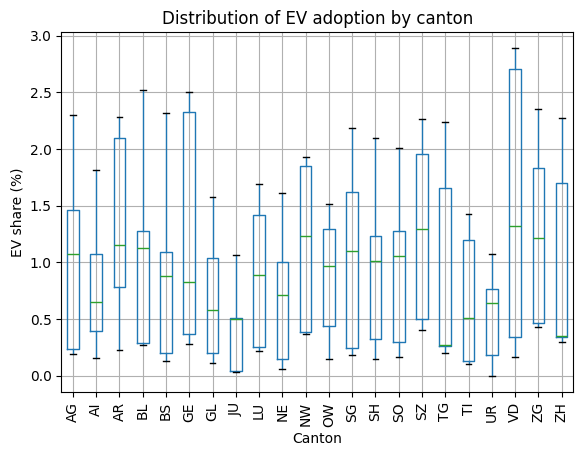


=== Our dataset in now ready to be modelized ===


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# All necessary files are loaded here (this is where 'elcom' is defined)

ev = pd.read_csv(INTER / "ev_registrations_per_canton_2015_2024.csv")
motor = pd.read_csv(INTER / "motorization_rate_2015_2024.csv")
gdp = pd.read_csv(INTER / "gdp_per_capita_2015_2024.csv")
pop = pd.read_csv(INTER / "population_balance_cantons_2015_2024.csv")
greens = pd.read_csv(INTER / "cantonal_parliaments_greens_2015_2024.csv")
climate = pd.read_csv(INTER / "canton_climate_co2_panel_2015_2024.csv")
elcom = pd.read_csv(INTER / "elcom_prices_by_operator_year_2014_2025.csv")

# Utility function to clean up canton codes (just in case)
CANTON_MAP = {
    "Zurich":"ZH","Zürich":"ZH","Berne":"BE","Bern":"BE","Lucerne":"LU","Luzern":"LU",
    "Uri":"UR","Schwyz":"SZ","Obwald":"OW","Obwalden":"OW","Nidwald":"NW","Nidwalden":"NW",
    "Glaris":"GL","Glarus":"GL","Zoug":"ZG","Zug":"ZG","Fribourg":"FR","Freiburg":"FR",
    "Soleure":"SO","Solothurn":"SO","Bâle-Ville":"BS","Basel-Stadt":"BS",
    "Bâle-Campagne":"BL","Basel-Landschaft":"BL","Schaffhouse":"SH","Schaffhausen":"SH",
    "Appenzell Rh.-Ext.":"AR","Appenzell Ausserrhoden":"AR","Appenzell Rh.-Int.":"AI",
    "Appenzell Innerrhoden":"AI","Saint-Gall":"SG","St. Gallen":"SG","Grisons":"GR",
    "Graubünden":"GR","Argovie":"AG","Aargau":"AG","Thurgovie":"TG","Thurgau":"TG",
    "Tessin":"TI","Ticino":"TI","Vaud":"VD","Valais":"VS","Wallis":"VS",
    "Neuchâtel":"NE","Genève":"GE","Geneva":"GE","Jura":"JU"
}

def map_canton_code(x):
    if pd.isna(x): return None
    x = str(x).strip()
    if x in CANTON_MAP: return CANTON_MAP[x]
    if re.fullmatch(r"[A-Z]{2}", x): return x
    return None

# Ensure that there is only clean canton codes
for d in [ev, gdp, pop, greens, climate]:
    if "canton" in d.columns and "canton_code" not in d.columns:
        d["canton_code"] = d["canton"].apply(map_canton_code)

#  Mapping Operators -> Cantons (ELCOM)

# Dictionary for major operators
operator_to_canton = {
    "BKW": "BE", "Bernische Kraftwerke": "BE",
    "EKZ": "ZH", "Elektrizitätswerke des Kantons Zürich": "ZH", "Stadt Zürich": "ZH",
    "SIG": "GE", "Services Industriels de Genève": "GE",
    "Groupe E": "FR", 
    "Romande Energie": "VD",
    "CKW": "LU",
    "AXPO": "AG", "AEW": "AG",
    "EWB": "BE", "IWB": "BS", "AIL": "TI", "FMV": "VS",
    "EGL": "GL", "Repower": "GR", "SN Energie": "SG",
    "EKS": "SH", "EWA": "UR", "WWZ": "ZG"
}

def find_canton_from_operator(op_name):
    op_name = str(op_name)
    for key, val in operator_to_canton.items():
        if key.lower() in op_name.lower():
            return val
    return None

# Apply the mapping to the 'elcom' DataFrame, which is now loaded.
elcom["canton_code_infer"] = elcom["operatorLabel"].apply(find_canton_from_operator)

# A. Price per canton (average of all operators in the district)
elcom_canton = (
    elcom.groupby(["year", "canton_code_infer"])["avg_price_after_discount_cts_per_kwh"]
    .mean()
    .reset_index()
    .rename(columns={
        "avg_price_after_discount_cts_per_kwh": "price_elcom_cts",
        "canton_code_infer": "canton_code"
    })
)

# B. National Price (Fallback in case some prices are missing)
elcom_national = (
    elcom.groupby("year")["avg_price_after_discount_cts_per_kwh"]
    .mean()
    .reset_index()
    .rename(columns={"avg_price_after_discount_cts_per_kwh": "price_national"})
)

# MERGE GLOBAL

df = ev.copy()

# Merging economic and demographic data
df = df.merge(motor[["canton_code","year","motorization_rate_per_1000"]],
              on=["canton_code","year"], how="left")

df = df.merge(gdp[["canton_code","year","gdp_per_capita_chf"]],
              on=["canton_code","year"], how="left")

df = df.merge(pop[["canton_code","year","pop_dec31","arrivals","departures"]],
              on=["canton_code","year"], how="left")

df = df.merge(greens[["canton_code","year","greens_share"]],
              on=["canton_code","year"], how="left")

df = df.merge(climate[["canton_code","year","summer_temp_c","winter_temp_c","co2_emissions_mt"]],
              on=["canton_code","year"], how="left")

# Electricity price merger
# 1. We try to stick to the specific price for the county.
df = df.merge(elcom_canton, on=["year", "canton_code"], how="left")

# 2. We stick the national price on everything.
df = df.merge(elcom_national, on="year", how="left")

# 3. We fill in the gaps in the regional price with the national price.
df["price_elcom_cts"] = df["price_elcom_cts"].fillna(df["price_national"])
df = df.drop(columns=["price_national"])

# EXPORT FINAL

out = INTER / "master_panel_2015_2024.csv"
df.to_csv(out, index=False)

print("MASTER DATASET CREATED:", out)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# STEP 1: Verifying the quality of the master dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

master_path = INTER / "master_panel_2015_2024.csv"
print("Chargement :", master_path.resolve())

assert master_path.exists(), f"Introuvable: {master_path}"

df = pd.read_csv(master_path)

print("\n=== General Overview ===")
print(df.head())

print("\n=== Columns ===")
print(df.columns.tolist())

print("\n=== Shape ===")
print(df.shape)

print("\n=== Years ===")
print("min year:", df["year"].min(), " | max year:", df["year"].max())

print("\n=== Number of cantons ===")
print(df["canton_code"].nunique(), "/", 26)

print("\n=== Number of lines par canton ===")
print(df.groupby("canton_code").size())


# ----------------------------------------------------------
# Check that there are NO duplicates for canton+year
# ----------------------------------------------------------
print("\n=== Checking for duplicates by canton/year ===")
dup = df[df.duplicated(subset=["canton_code","year"], keep=False)]
if len(dup) == 0:
    print("✔ No duplicates -> perfect.")
else:
    print("Duplicates detected :")
    display(dup)

# ----------------------------------------------------------
# Analysis of missing values
# ----------------------------------------------------------
print("\n=== % of missing values per column ===")
na = df.isna().mean().sort_values(ascending=False)
print(na)

# Option : afficher uniquement variables avec NA > 0
print("\nColumns with missing values :")
print(na[na > 0])

# ----------------------------------------------------------
# Descriptive statistics
# ----------------------------------------------------------
print("\n=== Descriptive statistics ===")
display(df.describe(include="all"))

# ----------------------------------------------------------
# Quick visualisation through histograms of our important features
# ----------------------------------------------------------
cols_to_plot = [
    "ev_reg_share",
    "motorization_rate_per_1000",
    "gdp_per_capita_chf",
    "price_elcom_cts",
    "summer_temp_c",
    "winter_temp_c",
    "co2_emissions_mt",
    "greens_share"
]

print("\n=== Histograms of important features ===")

for col in cols_to_plot:
    if col not in df.columns:
        print(f"⚠️ Missing columns : {col}")
        continue

    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=20, edgecolor="black")
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

# ----------------------------------------------------------
# "EV share per year" visualization
# ----------------------------------------------------------
plt.figure(figsize=(8,5))
df.groupby("year")["ev_reg_share"].mean().plot(marker='o')
plt.title("Average EV Adoption per year")
plt.xlabel("Year")
plt.ylabel("EV share (%)")
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Visualisation : EV share par canton (boxplot)
# ----------------------------------------------------------
plt.figure(figsize=(14,5))
df.boxplot(column="ev_reg_share", by="canton_code", rot=90)
plt.title("Distribution of EV adoption by canton")
plt.suptitle("")
plt.xlabel("Canton")
plt.ylabel("EV share (%)")
plt.grid(True)
plt.show()

print("\n=== Our dataset in now ready to be modelized ===")
